In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive')
zip_ref = zipfile.ZipFile("./drive/MyDrive//data/dataset.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile as zf
import os

data_dir='/tmp/dataset'
print(os.listdir(data_dir))

['rotational', 'combinational', 'translational']


In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from moviepy.editor import VideoFileClip

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
INIT_LR = 1e-4
EPOCHS = 10

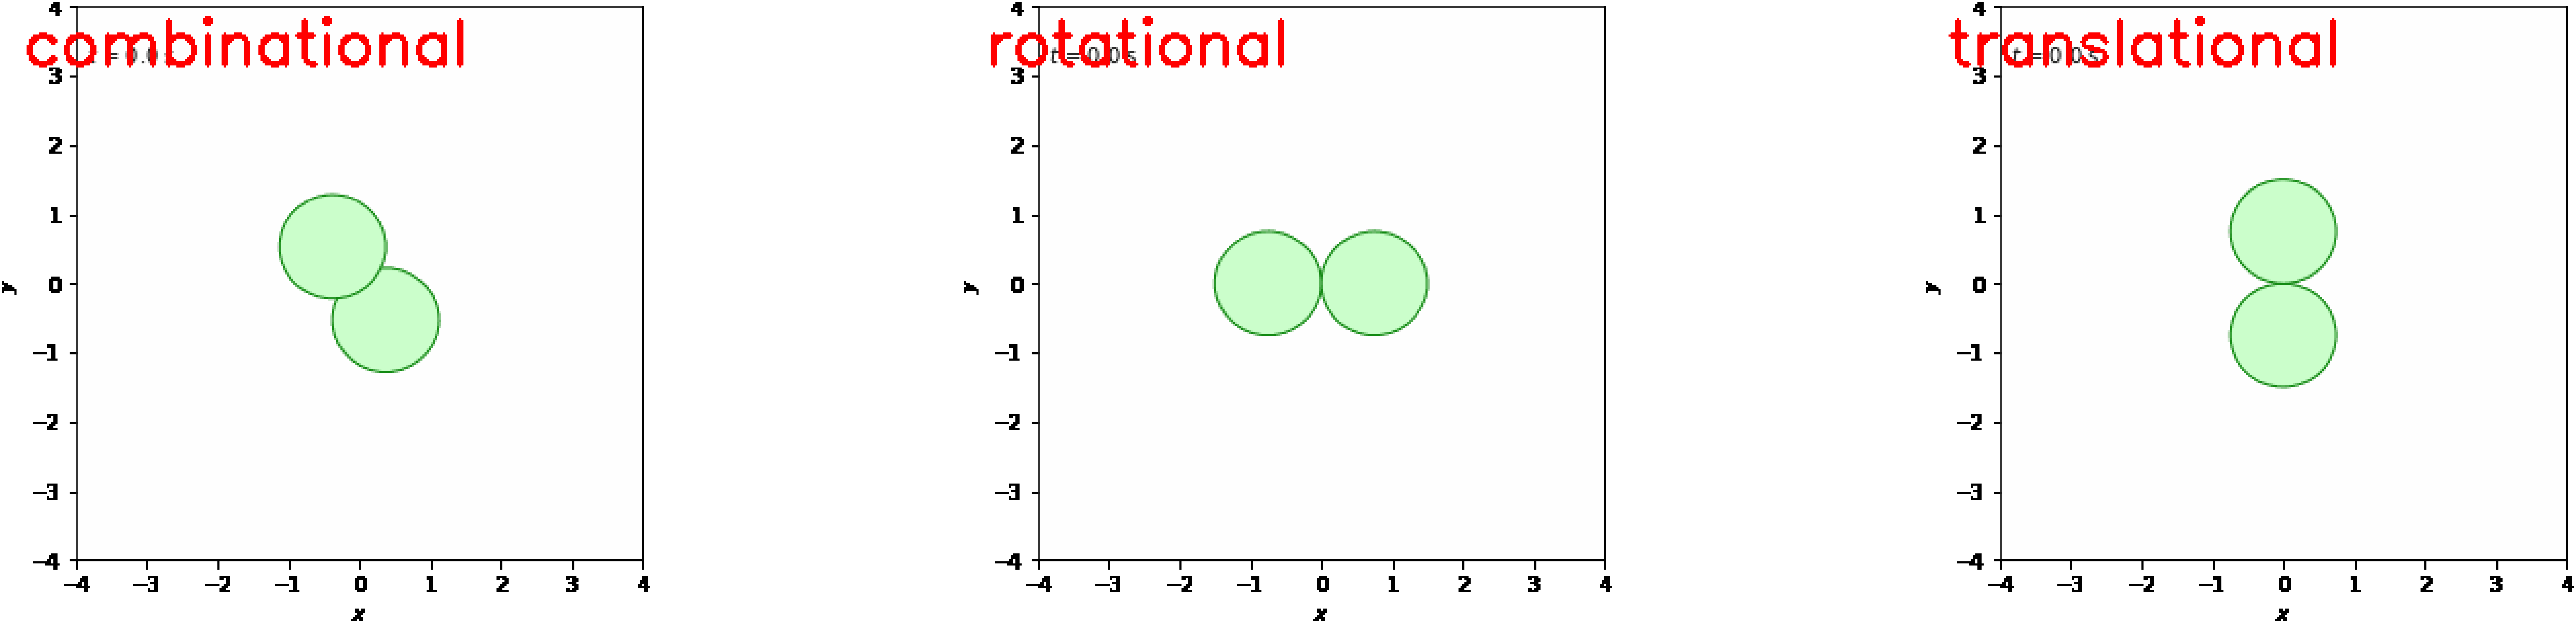

In [ ]:
# Create a Matplotlib figure
plt.figure(figsize = (224, 224))
all_classes_names = os.listdir(data_dir)

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 3)

for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'{data_dir}/{selected_class_Name}')
    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'{data_dir}/{selected_class_Name}/{selected_video_file_name}')
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [ ]:
image_height, image_width = 224, 224
max_images_per_class = 1000

dataset_directory = data_dir
classes_list = ["combinational", "translational", "rotational"]

model_output_size = len(classes_list)

In [ ]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (224, 224))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

In [ ]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [ ]:
features, labels = create_dataset()

Extracting Data of Class: combinational


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
base_model.trainable=False

In [ ]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
n_klasifikasi = 3
with strategy.scope():
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
  base_model.trainable=False

  headmodel = base_model.output
  headmodel = AveragePooling2D(pool_size=(7,7))(headmodel)
  headmodel = Flatten(name="flatten")(headmodel)
  headmodel = Dense(128, activation = "relu")(headmodel)
  headmodel = Dropout(0.5)(headmodel)
  headmodel = Dense(n_klasifikasi, activation="softmax")(headmodel)

  model = Model(inputs=base_model.input, outputs=headmodel)

  for layer in base_model.layers:
    layer.trainable = False

print("Mengkompilasi model ")
opt = Adam(learning_rate = INIT_LR, decay=INIT_LR/EPOCHS)
loss = CategoricalCrossentropy(label_smoothing=["smoothing"])
model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
#binary_crossentropy


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [ ]:
H = model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 4 , shuffle = True, validation_split = 0.3, callbacks = [early_stopping_callback])

Epoch 1/10
420/420 [==============================] - 26s 27ms/step - loss: 0.5554 - accuracy: 0.5536 - val_loss: 0.4494 - val_accuracy: 0.6833
Epoch 2/10
420/420 [==============================] - 6s 15ms/step - loss: 0.4609 - accuracy: 0.6607 - val_loss: 0.4125 - val_accuracy: 0.7153
Epoch 3/10
420/420 [==============================] - 6s 15ms/step - loss: 0.4319 - accuracy: 0.6798 - val_loss: 0.3885 - val_accuracy: 0.7181
Epoch 4/10
420/420 [==============================] - 6s 15ms/step - loss: 0.4108 - accuracy: 0.7119 - val_loss: 0.3770 - val_accuracy: 0.7444
Epoch 5/10
420/420 [==============================] - 6s 15ms/step - loss: 0.3929 - accuracy: 0.7125 - val_loss: 0.3603 - val_accuracy: 0.7306
Epoch 6/10
420/420 [==============================] - 6s 15ms/step - loss: 0.3841 - accuracy: 0.7310 - val_loss: 0.3543 - val_accuracy: 0.7569
Epoch 7/10
420/420 [==============================] - 6s 15ms/step - loss: 0.3770 - accuracy: 0.7393 - val_loss: 0.3389 - val_accuracy: 0.756

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)

19/19 [==============================] - 4s 64ms/step - loss: 0.3304 - accuracy: 0.7517


In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = H.history[metric_name_1]
  metric_value_2 = H.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

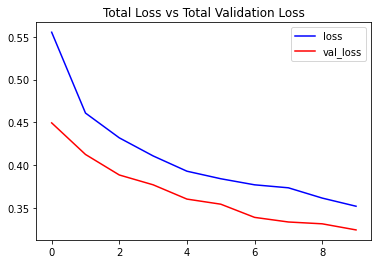

In [ ]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

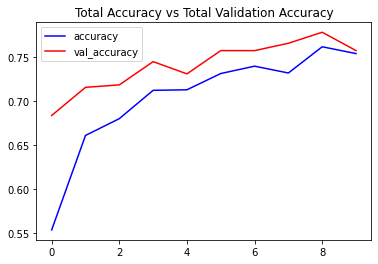

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def predict_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()


In [ ]:
video_title = 'volvox_cut'
output_directory = './'
input_video_file_path = f'{output_directory}/{video_title}.mp4'
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1

# Constructing The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

100%|██████████| 133/133 [00:01<00:00, 125.37it/s]


In [ ]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count): 

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read() 

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]

        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability*100):5}")
    
    # Closing the VideoCapture Object and releasing all resources held by it. 
    video_reader.release()

In [ ]:
video_title = 'volvox_cut'
output_directory = './'
input_video_file_path = f'{output_directory}/{video_title}.mp4'
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1

# Constructing The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction.
make_average_predictions(input_video_file_path, 40)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

error: ignored